In [1]:
import datetime

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

from direct_comments import create_df_direct_comments
from votes_over_time import create_votes_df


In [2]:
IMAGE_PATH = "../img/"
DATA_PATH = "../output/"

# Direct Comments

First we can see the direct comments (The ID_Posting of the UserPost is the ID_Posting_Parent of UserComment)
E.g at 2019-05-12 'NICE!' directly commented '!SeMteX!'s post

In [3]:
direct_comments = create_df_direct_comments()
direct_comments.sort_values(["UserPost", "UserComment"])

Postings loaded


/Users/vali/repos/tu_wien/group-10_homophily-and-assortative-mixing/scripts/direct_comments.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered.rename(columns={"UserCommunityName_x": "UserPost",


,UserPost,UserComment,ID_Posting,ID_Posting_Comment,CommentCreatedAt
189739,!SeMteX!,NICE!,1041381340,1041385498,2019-05-12 10:28:06.340
318660,"""Maxmustermann""",WilWil,1041840006,1041841069,2019-05-21 22:29:57.300
318661,"""Maxmustermann""",grauli,1041840006,1041840829,2019-05-21 22:23:14.597
318659,"""Maxmustermann""",rule eleven,1041840006,1041840316,2019-05-21 22:10:14.867
84879,"""Unschuldsvermutung""",held der arbeit klasse II,1041344453,1041344889,2019-05-10 15:39:26.690
...,...,...,...,...,...
19148,Žarko Jankovic,tt88,1041093644,1041094261,2019-05-02 13:02:20.050
3367,Žarko Jankovic,wakman,1041092153,1041092744,2019-05-02 12:14:41.927
19383,Žarko Jankovic,whatever - nevermind,1041095020,1041110668,2019-05-03 00:26:01.497
3366,Žarko Jankovic,ämpersand,1041092153,1041093895,2019-05-02 12:49:23.453


Now we can find some heavy users (having the most days with (direct comments) interaction)

In [4]:
direct_comments["InteractionDate"] = pd.to_datetime(direct_comments["CommentCreatedAt"]).dt.date
direct_comments["Users"] = direct_comments.apply(lambda x: str(sorted([str(x["UserPost"]), str(x["UserComment"])])), axis=1)

In [5]:
count_user_interaction = direct_comments.groupby("Users")["InteractionDate"].nunique().sort_values(ascending=False)
count_user_interaction

Users
['Leider Realist', 'humanökologische Pyramide']               27
['Flavio Marconi', 'eine kluge Katze kratzt keinen Köter']    27
['katze77', 'la tricoteuse']                                  26
['Resi Tupfer', 'ildiko1905']                                 26
['Kerscheplotzer', "soschaut'saus"]                           25
                                                              ..
['Eswarmalsoschön?', 'Igteil Fert']                            1
['Eswarmalsoschön?', 'Ich sag dazu nur....']                   1
['Eswarmalsoschön?', 'Humanismus ist heilbar']                 1
['Eswarmalsoschön?', 'Hudri Wudri']                            1
['ämpersand', 'Žarko Jankovic']                                1
Name: InteractionDate, Length: 334045, dtype: int64

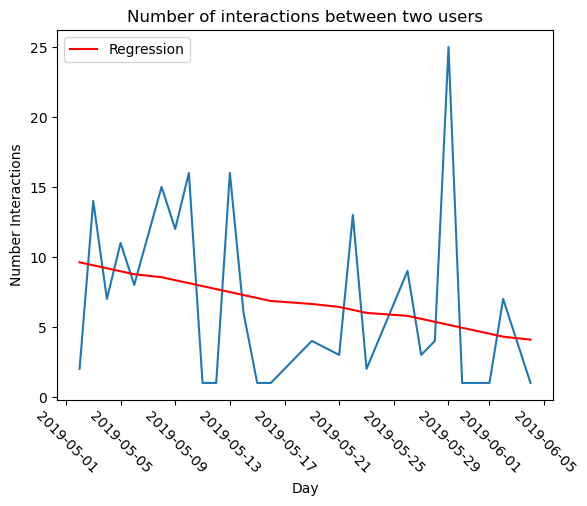

In [6]:
def plot_sum_user_counts(i, users):
    direct_comments_heavy_users = direct_comments[direct_comments["Users"] == users].sort_values("InteractionDate")
    user1, user2 = direct_comments_heavy_users.values[0][0:2]
    label = f"'{user1}', '{user2}'"
    res = direct_comments_heavy_users.groupby("InteractionDate")["ID_Posting_Comment"].count().sort_index()
    # direct_comments_heavy_users.groupby("InteractionDate")["CommentCreatedAt"]
    ax = res.sort_index().plot(label="_")
    [slope, intercept] = np.polyfit(range(0, len(res)), res.values, 1)
    plt.plot(res.index, (np.arange(0,len(res))*slope)+intercept, color = "red", label="Regression")


for i in [1]:
    users = count_user_interaction.index[i]
    plot_sum_user_counts(i, users)


plt.legend()
plt.xlabel("Day")
plt.ylabel("Number Interactions")
plt.xticks(rotation=-45)
plt.title("Number of interactions between two users")
plt.savefig(f"{IMAGE_PATH}comments_over_time.png")
plt.show()

#HeavyUsers (#Interactions >= 10): 75 
 (mean): 0.0044445156923014345


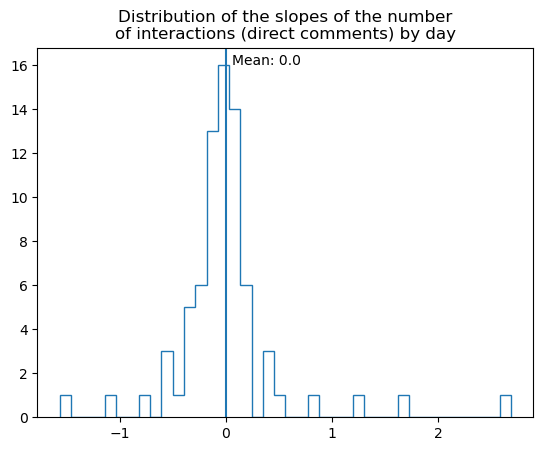

In [7]:
min_interaction = 10
heavy_users = count_user_interaction[count_user_interaction > min_interaction].index
print(f"#HeavyUsers (#Interactions >= {min_interaction}): {len(heavy_users)} ")

user_slopes = []
for users in heavy_users:
    comments_users = direct_comments[direct_comments["Users"] == users]
    date_comments = comments_users.groupby("InteractionDate")["ID_Posting_Comment"].count()
    [slope, intercept] = np.polyfit(range(0, len(date_comments)), date_comments.values, 1)

    user_slopes.append((users, (slope, intercept)))

slopes = np.asarray(list(map(lambda x: x[1][0], user_slopes)))
mean_slopes = np.mean(slopes)

print(f" (mean): {mean_slopes}")

counts, bins = np.histogram(slopes, bins=40)
plt.stairs(counts, bins)
plt.axvline(x=mean_slopes)
title = "Distribution of the slopes of the number\nof interactions (direct comments) by day"
plt.title(title)
plt.annotate(f'Mean: {round(mean_slopes, 2)}', xy=(np.mean(bins)/10 + mean_slopes, max(counts)))
title_clean = title.replace(' ', '_').replace('\n', '')
plt.savefig(f"../img/{title_clean}.png")
plt.show()

# Votings

Now we can check if users become similar in their voting behaviour. Therefore, we load the output of the scripts for the user_votes.
Here we see the user who posted the post and the user who commented at a certain time. Also we can see if the vote was negative (-1) or positive (+1)

In [8]:
user_votes = create_votes_df()
user_votes["InteractionDate"] = pd.to_datetime(user_votes["VoteCreatedAt"]).dt.date
user_votes["Users"] = user_votes.apply(lambda x: str(sorted([str(x["UserPost"]), str(x["UserVote"])])), axis=1)
user_votes

Votes loaded
Postings loaded


,UserPost,UserVote,VoteCreatedAt,Vote,InteractionDate,Users
0,Heckscheibenwischer,Kopper Stefan,2019-05-06 16:47:46.883,-1,2019-05-06,"['Heckscheibenwischer', 'Kopper Stefan']"
1,Heinz Fettleber,Kopper Stefan,2019-05-01 22:19:06.240,-1,2019-05-01,"['Heinz Fettleber', 'Kopper Stefan']"
2,markvienna,Kopper Stefan,2019-05-01 20:46:16.267,1,2019-05-01,"['Kopper Stefan', 'markvienna']"
3,Bruce Campbell,Dr. CMAP,2019-05-01 23:54:54.600,1,2019-05-01,"['Bruce Campbell', 'Dr. CMAP']"
4,Erdäpfelsack,Dr. CMAP,2019-05-01 20:59:29.910,1,2019-05-01,"['Dr. CMAP', 'Erdäpfelsack']"
...,...,...,...,...,...,...
3824979,Krugerrand,oswaldsee,2019-05-31 23:36:50.960,1,2019-05-31,"['Krugerrand', 'oswaldsee']"
3824980,RS69,youming,2019-06-02 00:11:51.430,-1,2019-06-02,"['RS69', 'youming']"
3824981,RS69,Dampfschiff St. Nepomuk,2019-06-02 00:07:53.280,-1,2019-06-02,"['Dampfschiff St. Nepomuk', 'RS69']"
3824982,Georg_Konrad,Pfefferstreuer,2019-06-01 23:01:07.253,1,2019-06-01,"['Georg_Konrad', 'Pfefferstreuer']"


Again we can search for heavy voters

In [9]:
count_user_interaction_dates = user_votes.groupby(["Users"])["InteractionDate"].nunique().sort_values(ascending=False)
count_user_interaction_dates

Users
['la tricoteuse', 'madame schmeckenwasser']    32
['katze77', 'la tricoteuse']                   32
['42', 'Trigintipetala']                       31
['Proudhon', 'la tricoteuse']                  31
['Trigintipetala', 'jeff5']                    31
                                               ..
['Fichtl_vom_Zauberland', 'bencostan']          1
['Fichtl_vom_Zauberland', 'bernhardposch']      1
['Fichtl_vom_Zauberland', 'berti russell']      1
['Fichtl_vom_Zauberland', 'bertolo']            1
['ümitza', 'Žarko Jankovic']                    1
Name: InteractionDate, Length: 2854684, dtype: int64

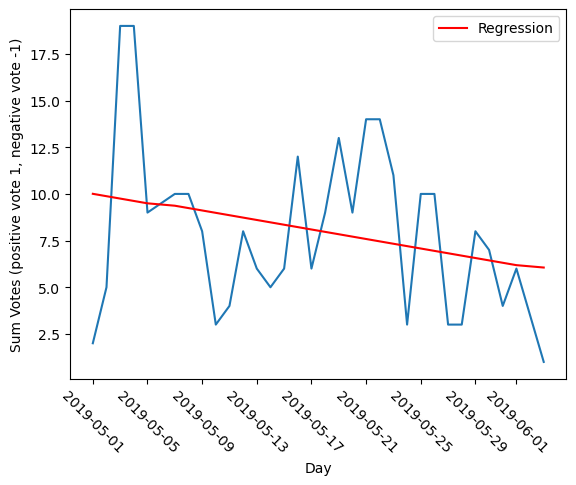

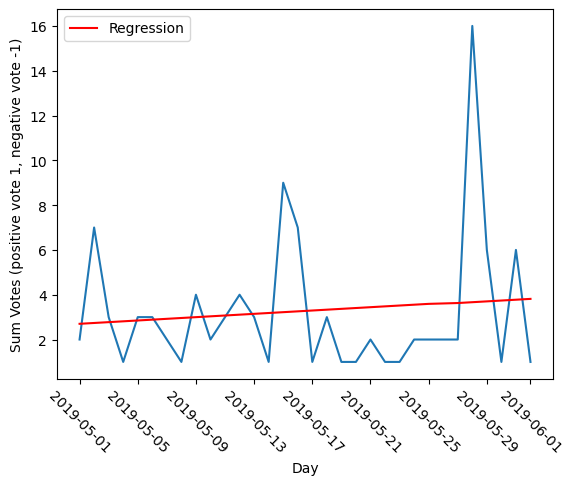

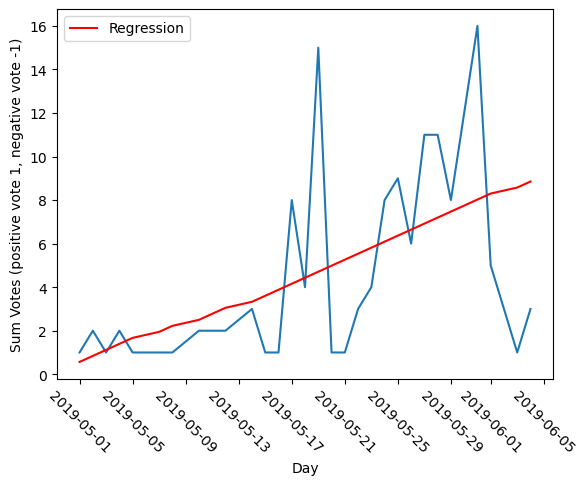

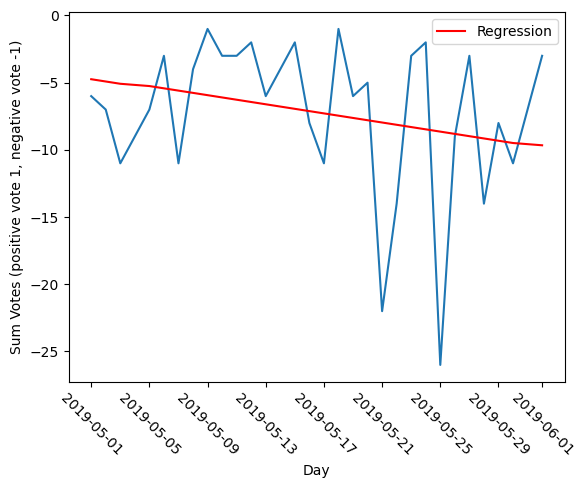

In [10]:
def plot_sum_user_counts(i, users):
    user_votes_heavy_users = user_votes[(user_votes["Users"] == users)].sort_values("VoteCreatedAt")
    user1, user2 = user_votes_heavy_users.values[0][0:2]
    label = f"'{user1}', '{user2}'"
    res = user_votes_heavy_users.groupby("InteractionDate")["Vote"].sum()
    ax = res.sort_index().plot(label="_")
    [slope, intercept] = np.polyfit(range(0, len(res)), res.values, 1)
    plt.plot(res.index, (np.arange(0,len(res))*slope)+intercept, color = "red", label="Regression")
    #plt.title("Sum of votes of two users")
    plt.legend()
    plt.xticks(rotation=-45)
    plt.ylabel("Sum Votes (positive vote 1, negative vote -1)")
    plt.xlabel("Day")
    plt.show()

for i, i_user in enumerate([1, 2, 3 , 8]):
    users = count_user_interaction_dates.index[i_user]
    plot_sum_user_counts(i, users)




In [11]:
min_interaction = 15
heavy_users = count_user_interaction_dates[count_user_interaction_dates > min_interaction].index
print(f"#HeavyUsers (#Interactions >= {min_interaction}): {len(heavy_users)} ")

positive_users = []
negative_users = []

for users in heavy_users:
    votes_users = user_votes[user_votes["Users"] == users]
    date_votes = votes_users.groupby("InteractionDate").agg({"Vote": ["sum", "mean"]})
    [slope, intercept] = np.polyfit(range(0, len(date_votes)), date_votes[('Vote',  'sum')], 1)

    if np.mean(date_votes[('Vote',  'mean')]) > 0:
        positive_users.append((users, (slope, intercept)))
    else:
        negative_users.append((users, (slope, intercept)))

#HeavyUsers (#Interactions >= 15): 342 


Distribution of the slopes for positive similar users (mean): 0.061302331158357974


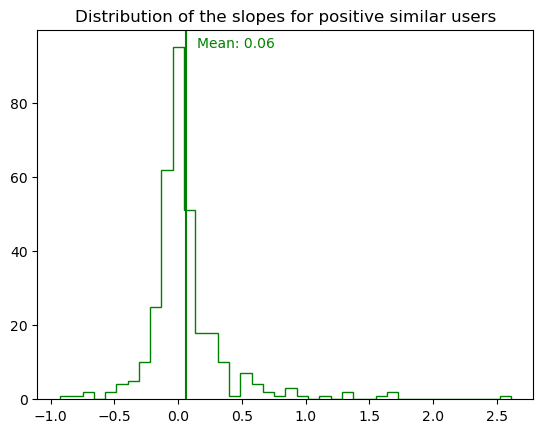

Distribution of the slopes for negative similar users (mean): 0.01333267460022669


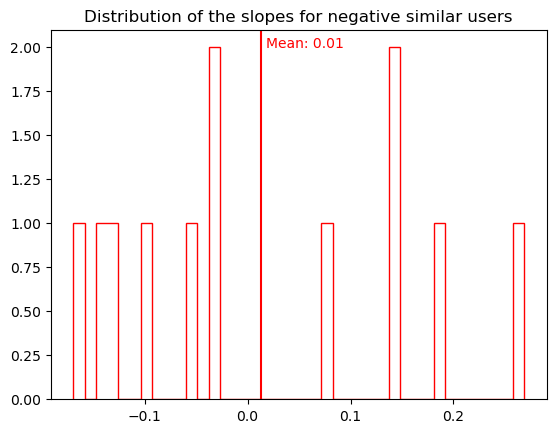

In [12]:
def plot_slope_hist(data, title, color):
    slopes = np.asarray(list(map(lambda x: x[1][0], data)))
    mean_slopes = np.mean(slopes)

    print(f"{title} (mean): {mean_slopes}")
    counts, bins = np.histogram(slopes, bins=40)

    plt.stairs(counts, bins, color = color)
    plt.axvline(x=mean_slopes, color = color)
    plt.title(title)
    plt.annotate(f'Mean: {round(mean_slopes, 2)}', xy=(np.mean(bins)/10 + mean_slopes, max(counts)), color=color)
    plt.savefig(f"../img/{title.replace(' ', '_')}.png")
    plt.show()



plot_slope_hist(positive_users, "Distribution of the slopes for positive similar users", "green")
plot_slope_hist(negative_users, "Distribution of the slopes for negative similar users", "red")

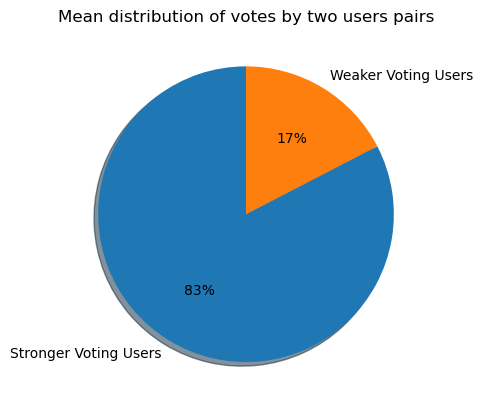

In [13]:
min_interaction = 15
heavy_users = count_user_interaction_dates[count_user_interaction_dates > min_interaction].index

strong_user = []
weak_user = []
for users in heavy_users:
    res = sorted(user_votes[user_votes["Users"] == users][["UserPost", "UserVote"]].value_counts().values)
    if len(res) == 1:
        res = [0, res[0]]
    res = np.asarray(res)
    res = res / np.sum(res)
    weak_user.append(res[0])
    strong_user.append(res[1])

strong_user = np.asarray(strong_user)
weak_user = np.asarray(weak_user)

plt.pie([strong_user.mean(), weak_user.mean()], labels=["Stronger Voting Users", "Weaker Voting Users"], autopct='%1.0f%%', shadow=True, startangle=90)
plt.title("Mean distribution of votes by two users pairs")
plt.savefig(f"{IMAGE_PATH}user_pairs_voting_distribution.png")
plt.show()

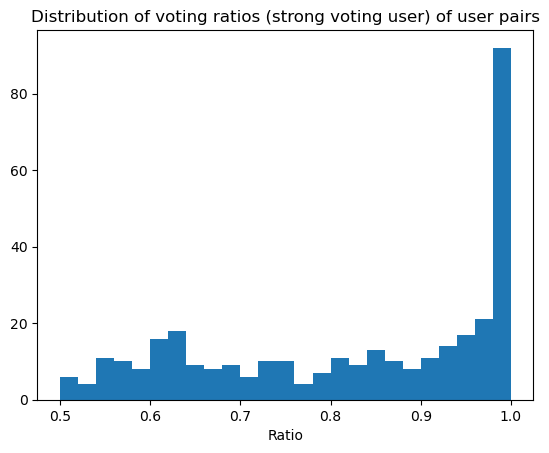

In [14]:
plt.hist(strong_user / (strong_user + weak_user), bins=25)
plt.title("Distribution of voting ratios (strong voting user) of user pairs")
plt.xlabel("Ratio")
plt.savefig(f"{IMAGE_PATH}user_pairs_voting_distribution_hist.png")
plt.show()

In [15]:
votes_positive = []
votes_negative = []
for users in heavy_users.values:
    data = user_votes[user_votes["Users"] == users]
    votes_positive.append(data[data["Vote"] == 1])
    votes_negative.append(data[data["Vote"] == -1])

df_votes_positive = pd.concat(votes_positive).groupby("InteractionDate")["Vote"].sum().sort_index()
df_votes_negative = pd.concat(votes_negative).groupby("InteractionDate")["Vote"].sum().sort_index()

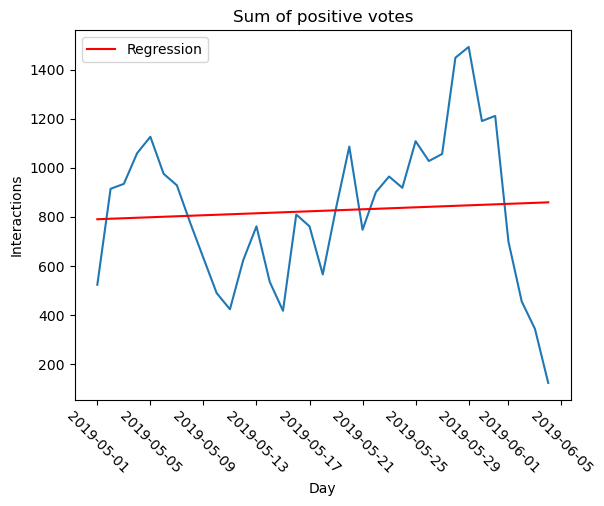

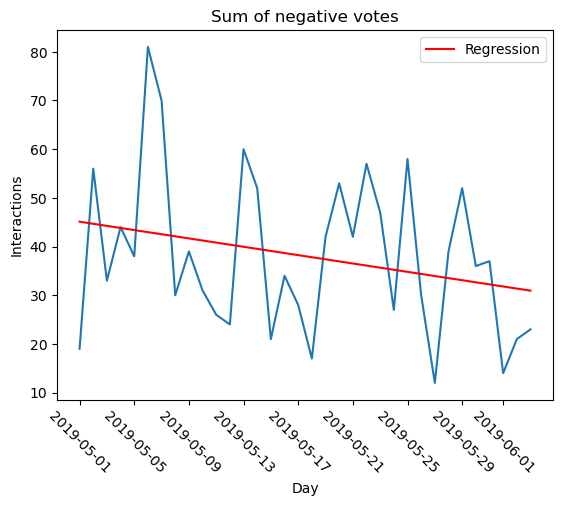

In [16]:
def plot_summed_interactions(df, title = ""):
    df.plot(label="_")
    [slope, intercept] = np.polyfit(range(0, len(df)), df.values, 1)
    x = df.index
    y = (np.arange(0,len(df))*slope)+intercept
    plt.plot(x, y, color = "red", label="Regression")
    plt.title(title)
    plt.xticks(rotation=-45)
    plt.xlabel("Day")
    plt.ylabel("Interactions")
    plt.legend()
    plt.savefig(f"../img/{title.replace(' ', '').lower()}.png")
    plt.show()

plot_summed_interactions(df_votes_positive, title = "Sum of positive votes")
plot_summed_interactions((-1)*df_votes_negative, title = "Sum of negative votes")

In [17]:
a = user_votes.groupby("Users")["Vote"].value_counts().rename("count").reset_index()

In [18]:
a[a["count"] > 100].set_index(["Users","Vote"]).sort_index()

,,count
Users,Vote,
"['*Tiefgang*', 'Rauschen im Blätterwald']",1,141
"['28543295-0d5c-4dc1-a702-89ad9aaca804', 'Christof Schwenniger']",1,201
"['28543295-0d5c-4dc1-a702-89ad9aaca804', 'Die Gezeichneten']",1,112
"['28543295-0d5c-4dc1-a702-89ad9aaca804', 'Dr. Usus Germanicus']",1,145
"['28543295-0d5c-4dc1-a702-89ad9aaca804', 'Trigintipetala']",1,171
...,...,...
"['mlzt', 'pasqual pinon']",1,102
"['mlzt', 'power-cat']",1,126
"['moving turtle', 'power-cat']",1,106


In [19]:
a.sort_index()

,Users,Vote,count
0,"[""'s koite Sopherl"", 'Cum hoc ergo propter hoc']",1,1
1,"[""'s koite Sopherl"", 'Fight Apathy or Don´t']",1,1
2,"[""'s koite Sopherl"", 'Kilian Schirrhackl']",1,1
3,"[""'s koite Sopherl"", 'Leos 12 Monkeys']",1,1
4,"[""...geht's eh noch?!"", ""D'Alessandro""]",-1,1
...,...,...,...
2926656,"['Österreicherinwürdegernesprechen', 'öqjkxmwv']",-1,1
2926657,"['Österreicherinwürdegernesprechen', 'ösi vom ...",-1,1
2926658,"['épouvantable', 'übersetzter']",-1,1
2926659,"['örly', 'österix']",1,1
